In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
import tqdm


sys.path.append('../pipeline_scripts/')
from pipeline_main import serialize_dictionary, pipeline, dist
from plotting_setup import *


In [2]:
data = pipeline(snap = 223, run = 'sink13fmr05', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:06<00:00, 662.86it/s]


In [3]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps.pkl', store = False)

In [4]:
map_data['maps'].shape

(289, 24300)

In [5]:
dist(np.array([0.19190214, -0.43587501,  0.28830718]), np.array([0.19187354, -0.43591025,  0.28830239])) * data.au_length

37.65686062345941

In [6]:
nside = 45
npix = hp.nside2npix(nside)
shell_r = 50 / data.au_length

time = map_data['time']

In [7]:
pct = np.arange(10, 100, 10)
pct_data = np.zeros((len(pct), len(time)))

In [8]:
nring = 4 * nside - 1

In [9]:
nring

179

In [10]:
for t in tqdm.tqdm(range(len(time))):
    map = map_data['maps'][t]
    bool_pos = map > 0; bool_neg = map < 0
    inflow_pixels = map[bool_pos]
    outflow_pixels = map[bool_neg]

    Lat_in, _ = hp.pix2ang(nside, np.arange(npix)[bool_pos])
    Lat_out, _ = hp.pix2ang(nside, np.arange(npix)[bool_neg])
    infall_index = np.argsort(inflow_pixels)[::-1]

    cell_area = hp.nside2pixarea(nside) * shell_r**2

    sphere_area = cell_area * npix 

    x = np.arange(len(inflow_pixels)) * cell_area / sphere_area * 100
    y = np.cumsum(inflow_pixels[infall_index]) / np.sum(inflow_pixels) * 100

    if len(y) == 0: continue

    indicies = [np.argmin(abs(y - p)) for p in pct]    
    pct_data[:,t] = x[indicies]
    if t == 421 -223 : break

pct_data[pct_data == 0] = np.nan

 69%|██████▊   | 198/289 [00:00<00:00, 551.92it/s]


In [11]:
deg_lat_in = (Lat_in - np.pi/2); deg_lat_out = (Lat_out - np.pi/2)

In [12]:
bins = np.unique(hp.pix2ang(nside, np.arange(npix))[0]) - np.pi/2

In [13]:
t_new = np.arange(0, (len(time)) * 200, 200)

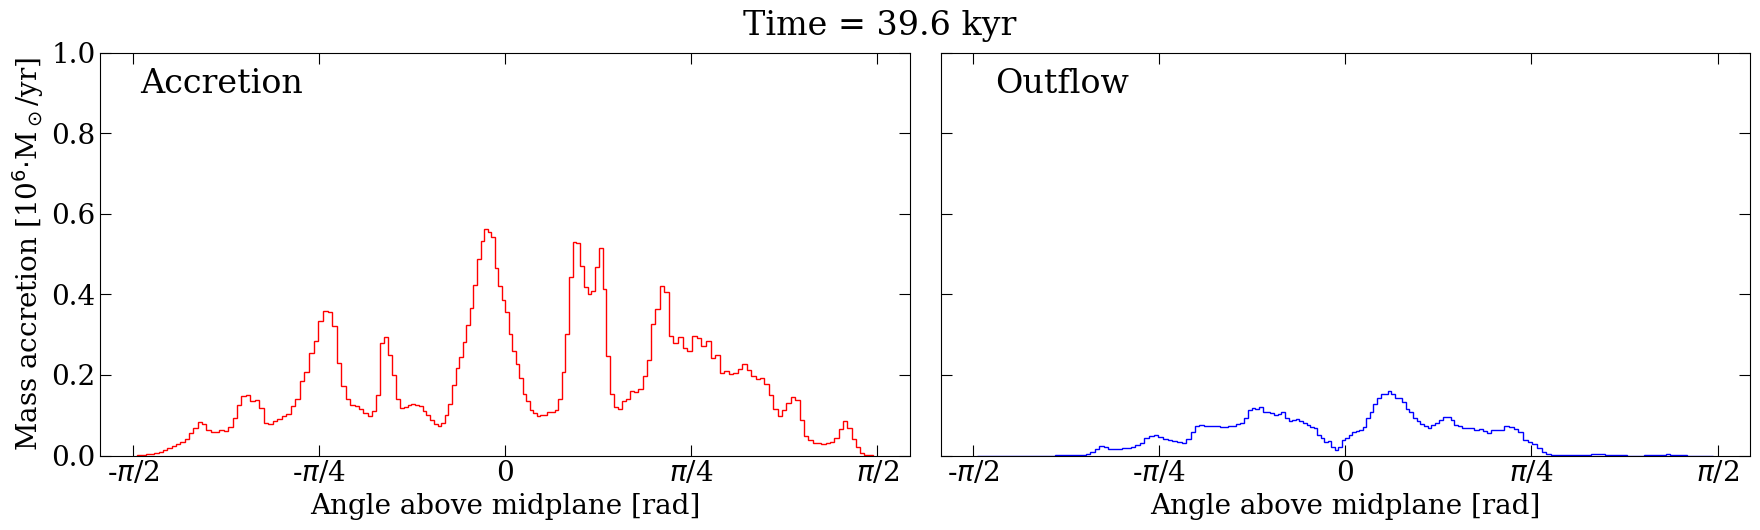

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6), sharey = True)

axs = ax[0]
axs.hist(deg_lat_in, histtype='step', bins = bins,  label = 'Inflow', weights=inflow_pixels* 1e6, color = 'red');
#axs.hist(deg_lat_out, histtype='step', bins = bins, label = 'Outflow');
axs.set(ylabel = 'Mass accretion [10$^6$$\cdot$M$_\odot$/yr]',  xlabel = 'Angle above midplane [rad]', ylim = (0,1))
values = np.linspace(-np.pi/2, np.pi/2, 5)
names = ['-$π$/2', '-$π$/4', '0', '$π$/4', '$π$/2']
axs.set_xticks(values); axs.set_xticklabels(names)
axs.set_title('Accretion', y=0.88, x = 0.15)

axs = ax[1]
axs.hist(deg_lat_out, histtype='step', bins = bins, label = 'Outflow',  weights=-outflow_pixels* 1e6, color = 'blue');
axs.set(xlabel = 'Angle above midplane [rad]')
values = np.linspace(-np.pi/2, np.pi/2, 5)
names = ['-$π$/2', '-$π$/4', '0', '$π$/4', '$π$/2']
axs.set_xticks(values); axs.set_xticklabels(names)
axs.set_title('Outflow', y=0.88, x = 0.15)

plt.suptitle(f'Time = {t_new[t]*1e-3} kyr', y = 0.9)
plt.tight_layout()
#plt.yscale('log')


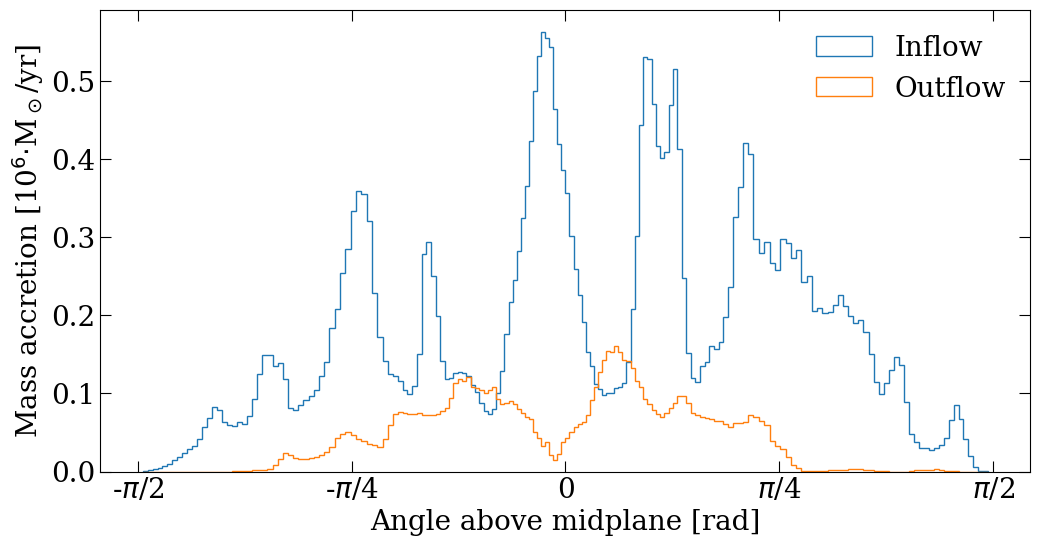

In [15]:
fig, axs = plt.subplots(figsize = (12, 6))

axs.hist(deg_lat_in, histtype='step', bins = bins, weights=inflow_pixels * 1e6, label = 'Inflow');
axs.hist(deg_lat_out, histtype='step', bins = bins, weights=-outflow_pixels * 1e6, label = 'Outflow');
axs.set(ylabel = 'Mass accretion [10$^6$$\cdot$M$_\odot$/yr]',  xlabel = 'Angle above midplane [rad]')
values = np.linspace(-np.pi/2, np.pi/2, 5)
names = ['-$π$/2', '-$π$/4', '0', '$π$/4', '$π$/2']
axs.set_xticks(values); axs.set_xticklabels(names)
#plt.yscale('log')
plt.legend(frameon = False)

In [16]:
values, np.pi/4

(array([-1.57079633, -0.78539816,  0.        ,  0.78539816,  1.57079633]),
 0.7853981633974483)

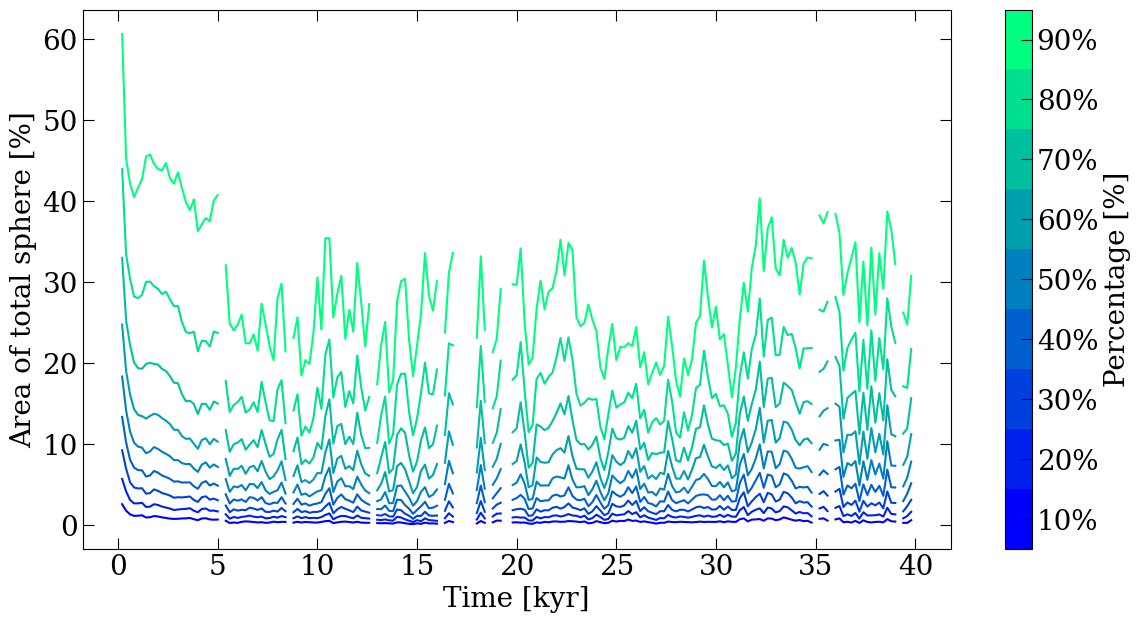

In [17]:
fig, axs = plt.subplots(figsize = (14, 7))

colors = plt.cm.winter(np.linspace(0,1, len(pct)))

axs.set(xlabel = 'Time [kyr]', ylabel = 'Area of total sphere [%]')

time_cut = 4e4

for i in range(len(pct)):
    axs.plot(time[time < time_cut] * 1e-3, pct_data[i][time < time_cut], label = f'{pct[i]} %', color = colors[i])

#axs.set_yscale('log')

# Create a ScalarMappable and add a colorbar


cmap = mcolors.ListedColormap(colors)
bounds = np.linspace(0, len(pct), len(pct) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=axs, ticks=np.arange(len(pct)) + 0.5)
cbar.set_label('Percentage [%]')  # Label for the colorbar
cbar.set_ticks(np.arange(len(pct)) + 0.5)  # Adjust ticks to center them on each color
cbar.set_ticklabels([f'{p}%' for p in pct])  # Customize the tick labels